In [1]:
using RigidBodyDynamics
using ForwardDiff
using Plots
using MeshCatMechanisms

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [4]:
struct Model
    f::Function
    n::Int
    m::Int

    function Model(f::Function, n::Int64, m::Int64)
        new(f,n,m)
    end

    function Model(mech::Mechanism)
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\u - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, m)
    end
end

function Model(urdf::String)
    mech = parse_urdf(Float64,urdf)
    Model(mech)
end

struct Objective
    Q::Array{Float64,2}
    R::Array{Float64,2}
    Qf::Array{Float64,2}
    tf::Float64
    x0::Array{Float64,1}
    xf::Array{Float64,1}
end

In [5]:
struct Solver
    model::Model
    obj::Objective
    dt::Float64
    fd::Function  # discrete dynamics
    F::Function
    N::Int
    function Solver(model::Model, obj::Objective, dt::Float64)
        obj_n = size(obj.Q, 1)
        obj_m = size(obj.R, 1)
        @assert obj_n == model.n
        @assert obj_m == model.m

        # RK4 integration
        fd = rk4(model.f, dt)
        F(x,u) = Jacobian(fd,x,u)
        N = Int(floor(obj.tf/dt))
        new(model, obj, dt, fd, F, N)
    end
end

function rk4(f::Function,dt::Float64)
    # Runge-Kutta 4
    k1(x,u) = dt*f(x,u)
    k2(x,u) = dt*f(x + k1(x,u)/2.,u)
    k3(x,u) = dt*f(x + k2(x,u)/2.,u)
    k4(x,u) = dt*f(x + k3(x,u), u)
    fd(x,u) = x + (k1(x,u) + 2.*k2(x,u) + 2.*k3(x,u) + k4(x,u))/6.
end

function midpoint(f::Function,dt::Float64)
    fd(x,u) = x + f(x + f(x,u)*dt/2., u)*dt
end

function Jacobian(f::Function,x::Array{Float64,1},u::Array{Float64,1})
    f1 = a -> f(a,u)
    f2 = b -> f(x,b)
    fx = ForwardDiff.jacobian(f1,x)
    fu = ForwardDiff.jacobian(f2,u)
    return fx, fu
end

Jacobian (generic function with 1 method)

In [22]:
#iLQR
function rollout(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    X[:,1] = solver.obj.x0
    for k = 1:solver.N-1
        X[:,k+1] = solver.fd(X[:,k],U[:,k])
    end
    return X
end

# function rollout(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},X_::Array{Float64,2},U_::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2},alpha::Float64)
#     X_prev = copy(X)
#     X[:,1] = solver.obj.x0
#     for k = 1:solver.N-1
#       U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*d[:,k]
#       X[:,k+1] = solver.fd(X[:,k],U_[:,k]);
#     end
#     return X, U_
# end

# function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
#     N = solver.N
#     X_[:,1] = solver.obj.x0;
#     for k = 2:N
#         a = alpha*(d[:,k-1]);
#         delta = (X_[:,k-1] - X[:,k-1])

#         U_[:, k-1] = U[:, k-1] - K[:,:,k-1]*delta - a;
#         X_[:,k] = solver.fd(X_[:,k-1], U_[:,k-1]);
#     end
# end

function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf
    
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
#     K = zeros(m,n,N-1)
#     l = zeros(m,N-1)
    
    S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        
        Qx = lx + fx'*s
        Qu = lu + fu'*s
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu)))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += d[:,k]'*Qu
        v2 += d[:,k]'*Quu*d[:,k]
        
        k = k - 1;
    end
    return K, d, v1, v2
end

function forwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2},J::Float64,v1,v2,c1::Float64=0.0,c2::Float64=1.0)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X_prev = copy(X)
    J_prev = copy(J)
    U_ = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0

    while J > J_prev || z < c1 || z > c2 
        X[:,1] = solver.obj.x0
        for k = 1:N-1
            U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*d[:,k]
            X[:,k+1] = solver.fd(X[:,k],U_[:,k]);
        end
#         X_, U_ = rollout(solver,X,U,X_,U_,K,d,alpha)

         J = cost(solver,X,U_)
#        J = cost(solver,X_,U_)
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
      return X, U_, J
#     return X_, U_, J
end

function solve(solver::Solver,iterations::Int64=100,eps::Float64=1e-3;control_init::String="random")
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X = zeros(n,N)
    X_ = zeros(n,N)
    
    if control_init == "random"
        U = 10.0*rand(m,N-1)
    else
        U = zeros(m,N-1)
    end
    U_ = zeros(m,N-1)
    
    K = zeros(m,n,N-1)
    d = zeros(m,N-1)
        
    X = rollout(solver, X, U)
    J_prev = cost(solver, X, U)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, d, v1, v2 = backwardpass(solver,X,U,K,d)
        X, U, J = forwardpass(solver,X,U,K,d,J_prev,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 3 methods)

In [24]:
# # # Double Pendulum
# urdf = "doublependulum.urdf"
# dp = Model(urdf)

# # initial and goal states
# x0 = [0.;0.;0.;0.]
# xf = [pi;0.;0.;0.]

# # costs
# Q = 0.0001*eye(dp.n)
# Qf = 250.0*eye(dp.n)
# R = 0.0001*eye(dp.m)

# # simulation
# tf = 1.0
# dt = 0.1

# obj = Objective(Q,R,Qf,tf,x0,xf)
# solver = Solver(dp,obj,dt);

####
# Dubins car parallel park
function fc(x,u)
    return [u[1]*cos(x[3]); u[1]*sin(x[3]); u[2]]
end

n = 3 # number of states
m = 2 # number of controls

car = Model(fc,n,m)

# initial and goal states
x0 = [0.;0.;0.]
xf = [0.;1.;0.]

# costs
Q = 0.001*eye(car.n)
Qf = 100.0*eye(car.n)
R = 0.001*eye(car.m)

# simulation
tf = 5.0
dt = 0.01

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(car,obj,dt);

# initialization
# N = solver.N
# n = solver.model.n
# m = solver.model.m
# X = zeros(n,N)
# X_= zeros(size(X))

# U = 10.0*rand(m,N-1)

# U_ = zeros(size(U))

# K = zeros(m,n,N-1)
# d = zeros(m,N-1)
# v1 = 0.
# v2 = 0.

# first rollout
# println("X1: $X_")
# println("U1: $U")
#rollout!(solver,X,U,K,d,X_,U_,1.0)
# println("X2: $X_")
# println("U2: $U_")
# J_prev = cost(solver.obj,X,U)
# println("Initial Cost: $J_prev\n")
# println("K1: $K")
# backwardpass!(solver,X,U,K,d,v1,v2)
# println("K2: $K")

X, U = @time solve(solver; control_init="random");

Initial Cost: 31258.285295892947

*** Iteration: 1 ***
New cost: 1922.9156479137212
- Expected improvement: 93575.92751445854
- Actual improvement: 29335.369647979227
- (z = 0.31349269440526334)

*** Iteration: 2 ***
New cost: 1007.9854200907088
- Expected improvement: 2132.2902508003176
- Actual improvement: 914.9302278230124
- (z = 0.429083342420015)

*** Iteration: 3 ***
New cost: 836.0283108088215
- Expected improvement: 1053.563623384187
- Actual improvement: 171.95710928188726
- (z = 0.1632147365999009)

*** Iteration: 4 ***
New cost: 546.9874442438395
- Expected improvement: 412.0970012254459
- Actual improvement: 289.040866564982
- (z = 0.7013903661163903)

*** Iteration: 5 ***
New cost: 488.96906131350636
- Expected improvement: 58.16068958834986
- Actual improvement: 58.01838293033313
- (z = 0.9975532157712719)

*** Iteration: 6 ***
New cost: 447.80982662828154
- Expected improvement: 52.84765495435452
- Actual improvement: 41.15923468522482
- (z = 0.7788280240774127)

*** It

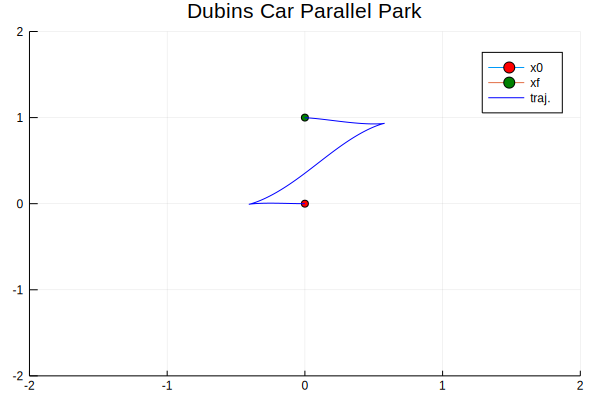

In [25]:
plot((x0[1],x0[2]),marker=(:circle,"red"),label="x0")
plot!((xf[1],xf[2]),marker=(:circle,"green"),label="xf")
plot!(X[1,:],X[2,:],title="Dubins Car Parallel Park",label="traj.",color="blue",xlim=(-2,2),ylim=(-2,2))

In [ ]:
W = plot(linspace(0,tf,size(X,2)),[U[1,1] U[1,:]']',title="Double Pendulum")
W = plot!(linspace(0,tf,size(X,2)),[U[2,1] U[2,:]']',ylabel="Control")

In [ ]:
vis = MechanismVisualizer(doublependulum,URDFVisuals(urdf));
IJuliaCell(vis)

In [ ]:
for i = 1:size(X,2)
    set_configuration!(state, X[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(dt)
end